# Creating optimizers from scratch

In [1]:
from fastai.vision.all import *

## Data creation

In [3]:
path = untar_data(URLs.IMAGENETTE_160)
Path.BASE_PATH = path

In [7]:
path.ls(), (path/'train').ls()

((#4) [Path('train'),Path('val'),Path('.DS_Store'),Path('noisy_imagenette.csv')],
 (#11) [Path('train/n02102040'),Path('train/n03445777'),Path('train/n03394916'),Path('train/n03425413'),Path('train/n03000684'),Path('train/n01440764'),Path('train/n03888257'),Path('train/n03417042'),Path('train/.DS_Store'),Path('train/n02979186')...])

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(valid_name='val'),
    get_y=parent_label,
    item_tfms=Resize(160),
    batch_tfms=aug_transforms(min_scale=0.75, size=128)
).dataloaders(path, bs=128)

def get_learner(**kwargs):
    return vision_learner(dls, resnet34, pretrained=False,
                    metrics=accuracy, **kwargs).to_fp16()

SuggestedLRs(valley=0.0004786300996784121)

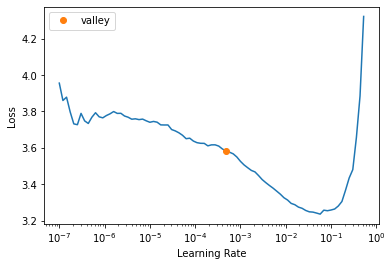

In [14]:
learn = get_learner()
learn.lr_find() #0.005

In [19]:
doc(Optimizer)

,Type,Default,Details
params,Tensor,,Parameters and hyper parameters
cbs,list,,Optimizer callbacks
train_bn,bool,True,Batch normalization is always trained
defaults,,,No Content


## SGD

In [22]:
learn = get_learner(opt_func=SGD)
learn.fit_one_cycle(3, 0.005)

epoch,train_loss,valid_loss,accuracy,time
0,3.290718,2.880478,0.178089,00:11
1,2.892906,2.131830,0.276943,00:11
2,2.670070,2.015708,0.312102,00:11


## Momentum

In [55]:
def momentum_step(p, lr, mom, grad_av=0, **kwargs):
    grad_av = mom*grad_av + (1 - mom)*p.grad.data
    p.data -= lr*grad_av
    
learn = get_learner(opt_func=partial(Optimizer, cbs=momentum_step, mom=0.9))
learn.fit_one_cycle(3, 0.005)

epoch,train_loss,valid_loss,accuracy,time
0,3.628242,11.389930,0.081529,00:12
1,3.498630,2.611330,0.137580,00:12
2,3.420885,2.578982,0.152102,00:12


In [46]:
# without 1-mom
def momentum_step(p, lr, mom, grad_av=0, **kwargs):
    grad_av = mom*grad_av + p.grad.data
    p.data -= lr*grad_av
    
learn = get_learner(opt_func=partial(Optimizer, cbs=momentum_step, mom=0.9))
learn.fit_one_cycle(3, 0.005)

epoch,train_loss,valid_loss,accuracy,time
0,3.243884,3.115826,0.203312,00:12
1,2.853906,2.123694,0.278471,00:12
2,2.683579,2.008859,0.310064,00:12


## RMSProp

In [53]:
def rms_prop_step(p, lr, sqr_mom, eps, grad_sqr=0, **kwargs):
    grad_sqr = sqr_mom*grad_sqr + (1-sqr_mom)*p.grad.data**2
    p.data -= lr*p.grad.data/torch.sqrt(grad_sqr + eps)
    
learn = get_learner(opt_func=partial(Optimizer, cbs=rms_prop_step, sqr_mom=0.99, eps=1e-7))
learn.fit_one_cycle(3, 0.005)

epoch,train_loss,valid_loss,accuracy,time
0,4.388772,295.678040,0.112102,00:12
1,3.004055,2.490513,0.128153,00:12
2,2.443463,2.205627,0.178089,00:12


In [54]:
# without 1-sqr_mom
def rms_prop_step(p, lr, sqr_mom, eps, grad_sqr=0, **kwargs):
    grad_sqr = sqr_mom*grad_sqr + p.grad.data**2
    p.data -= lr*p.grad.data/torch.sqrt(grad_sqr + eps)
    
learn = get_learner(opt_func=partial(Optimizer, cbs=rms_prop_step, sqr_mom=0.99, eps=1e-7))
learn.fit_one_cycle(3, 0.005)

epoch,train_loss,valid_loss,accuracy,time
0,2.941177,5.653687,0.148790,00:12
1,2.300845,1.902648,0.339873,00:12
2,1.809556,1.471902,0.495541,00:12


## Adam

In [58]:
def adam_step(p, lr, mom1, mom2, eps, grad_av=0, grad_sqr=0, i=0, **kwargs):
    grad_av = mom1*grad_av + (1-mom1)*p.grad.data
    norm_grad_av = grad_av/(1 - mom1*(i+1))
    grad_sqr = mom2*grad_sqr + (1 - mom2)*p.grad.data**2
    norm_grad_sqr = grad_sqr/(1 - mom2*(i+1))
    i += 1
    p.data -= lr*norm_grad_av/torch.sqrt(norm_grad_sqr + eps)
    
learn = get_learner(opt_func=partial(Optimizer, cbs=adam_step, mom1=0.9, mom2=0.99, eps=1e-7))
learn.fit_one_cycle(3, 0.005)

epoch,train_loss,valid_loss,accuracy,time
0,3.043078,419.097687,0.099873,00:13
1,2.397956,1.970937,0.287643,00:13
2,1.905926,1.587586,0.462930,00:13
